# Project 1

In [68]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
import pandas
from math import lgamma

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
smallDf = pandas.read_csv('small.csv')
smallDf

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1
5,2,3,1,1,1,1,1,1
6,3,1,1,1,2,1,1,1
7,1,1,1,1,1,1,2,1
8,2,1,1,2,1,2,1,2
9,1,2,1,1,3,2,1,2


In [70]:
list(smallDf)

['age',
 'portembarked',
 'fare',
 'numparentschildren',
 'passengerclass',
 'sex',
 'numsiblings',
 'survived']

In [207]:
def initialize(df):
    headers = list(df)
    g = nx.DiGraph()
    for header in headers:
        inst_vals = df[header].unique()
        instantiations = np.max(inst_vals)
        g.add_node(header, inst=instantiations)
    return g

def bayes_score(g, df):
    num_rows = len(df)
    nodes = g.nodes(data=True)
    score = 0
    for n,d in nodes:
        r_i = d['inst']
        parents = list(g.predecessors(n))
        parent_score = 0
        if (len(parents) > 0):
            parent_insts = df.groupby(parents).size().reset_index(name='counts')
            for p in parent_insts.counts:
                parent_score += lgamma(r_i) - lgamma(r_i + p)
        else:
            parent_score = lgamma(r_i) - lgamma(r_i + num_rows)

        child_list = [n] + parents
        child_insts = df.groupby(child_list).size().reset_index(name='counts')
        child_score = 0
        for c in child_insts.counts:
            child_score += lgamma(1 + c) - lgamma(1)
        score += parent_score + child_score
    return score

def k2(init_g, df, iters):
    g = init_g.copy()
    best_score = bayes_score(g, df)
    for i in range(iters):
        for n in g.nodes():
            for p in g.nodes():
                if (n == p):
                    continue
                # try removing edge
                if (g.has_edge(p, n)):
                    best_score = test_fitness(g.remove_edge, g.add_edge, n, p, g, df, best_score)
                    # if removing wasn't better, try reversing
                    if (g.has_edge(p, n)):
                        best_score = test_fitness(reverse_edge(g), reverse_edge(g), n, p, g, df, best_score)
                else: # try adding edge
                    best_score = test_fitness(g.add_edge, g.remove_edge, n, p, g, df, best_score)

    return g, best_score


def test_fitness(fn, fnrev, n, p, g, df, best_score):
    fn(p, n)
    score = bayes_score(g, df)

    if (score <= best_score or has_cycle(g)):
        fnrev(p, n)
        score = best_score
    return score

def reverse_edge(graph):
    def rev_with_g(p, n):
        if (graph.has_edge(p,n)):
            graph.remove_edge(p, n)
            graph.add_edge(n, p)
    return rev_with_g


def has_cycle(g):
    cycle = False
    try:
        cycle = len(nx.algorithms.cycles.find_cycle(g)) > 0
    except:
        pass
    return cycle

In [209]:
og = initialize(smallDf)
print(bayes_score(og, smallDf))

tg, best_score = k2(og, smallDf, 2)

print(best_score)
print(bayes_score(tg, smallDf))

-4166.2258587849055
-3834.5287033001273
-3844.691803123809
-3844.691803123809


In [198]:
mediumDf = pandas.read_csv('medium.csv')
mg = initialize(mediumDf)
print(bayes_score(mg, mediumDf))

k2mg, best_score = k2(mg, mediumDf, 2)

print(best_score)
print(bayes_score(k2mg, mediumDf))

-45388.958426241225
-42552.556388820456
-42993.75051531821


In [199]:
largeDf = pandas.read_csv('large.csv')
lg = initialize(largeDf)
print(bayes_score(lg, largeDf))

k2lg, best_score = k2(lg, largeDf, 1)

print(best_score)
print(bayes_score(k2lg, largeDf))

-317497.08919749025
-268150.75632544985
-268150.75632544985


In [203]:
write_gph(k2lg, "large.gph")

In [204]:
write_gph(k2mg, "medium.gph")

In [205]:
write_gph(tg, "small.gph")

In [181]:
g = initialize(smallDf)

g.add_edge('numsiblings','numparentschildren')
g.add_edge('numsiblings','passengerclass')
g.add_edge('numparentschildren','sex')

print(score(g, smallDf))

-4106.483423833117


In [202]:
def write_gph(dag, filename):
    with open(filename, 'w') as f:
        for edge in dag.edges():
            f.write("{}, {}\n".format(edge[0], edge[1]))


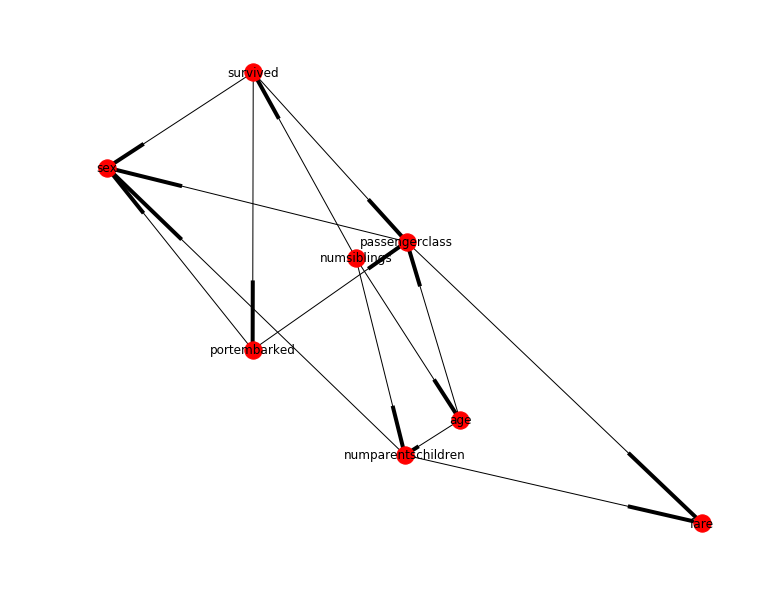

In [216]:
nx.draw(tg, with_labels=True)
plt.show()
plt.savefig("small.png")

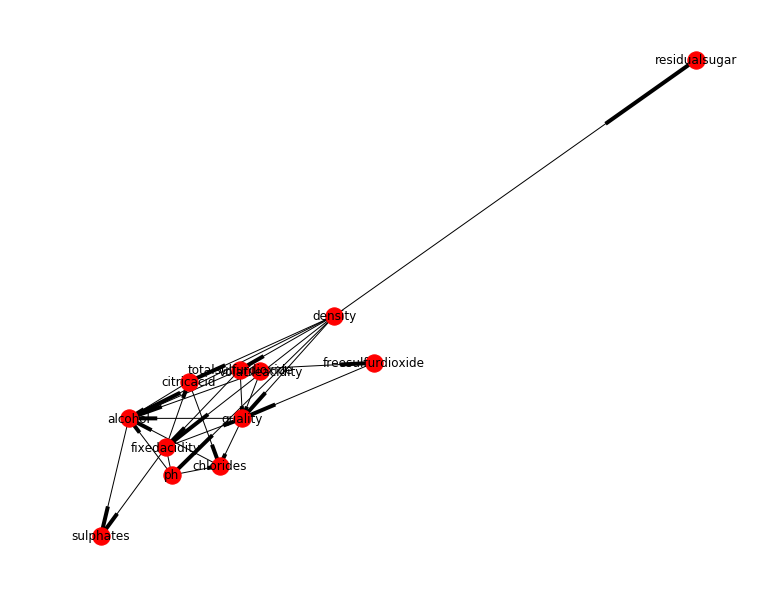

In [217]:
nx.draw(k2mg, with_labels=True)
plt.show()
plt.savefig("medium.png")

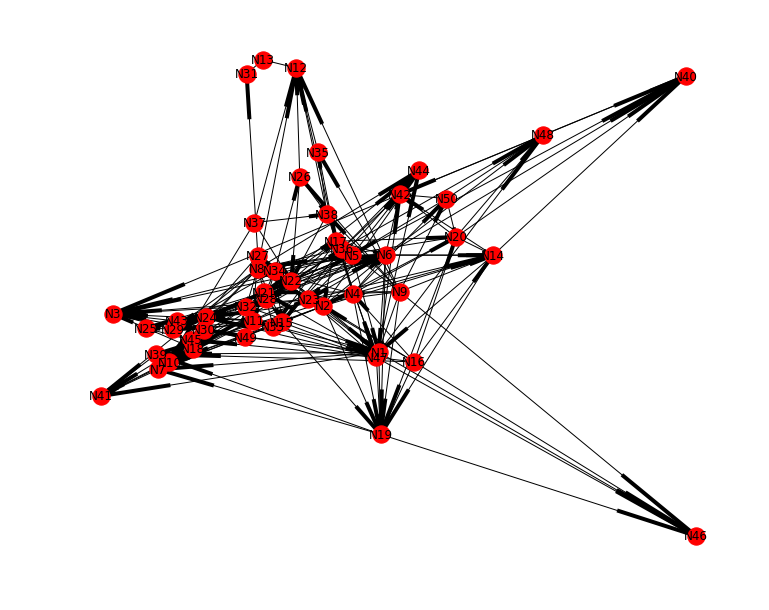

In [218]:
nx.draw(k2lg, with_labels=True)
plt.show()
plt.savefig("large.png")